In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iDEA
import pickle
import time
from pathlib import Path

# Initialize the system
points = 231
l = 10
x = np.linspace(-l, l, points)
dx = x[1] - x[0]
omega = 0.3275
v_ext = 0.5 * omega**2 * (x**2)
v_int = np.zeros([len(x), len(x)])
qho_single = iDEA.system.System(x, v_ext, v_int, electrons="u")
qho_double = iDEA.system.System(x, v_ext, v_int, electrons="ud")


In [2]:
states_single = {}
states_double = {}
occupied_info = []

directory = Path("states")

for i in range(0, 10):
    file_path = directory / f"qho_single_state_{i}_{points}_points.pkl"
    try:
        with file_path.open("rb") as file:
            states_single[i] = pickle.load(file)
    except FileNotFoundError:
        print(f"File state_{i}.pkl not found.")
    except Exception as e:
        print(f"An error occurred while loading state_{i}.pkl: {e}")

for i in range(0, 10):
    file_path = directory / f"qho_double_state_{i}_{points}_points.pkl"
    try:
        with file_path.open("rb") as file:
            states_double[i] = pickle.load(file)
    except FileNotFoundError:
        print(f"File state_{i}.pkl not found.")
    except Exception as e:
        print(f"An error occurred while loading state_{i}.pkl: {e}")

file_path = "occupied_info_231.pkl"
with open(file_path, "rb") as file:
    occupied_info = pickle.load(file)





In [3]:
energies_single = []
for key, value in states_single.items():
    energies_single.append(value.energy)

energies_double = []
for key, value in states_double.items():
    energies_double.append(value.energy)

analytic_energies = []
for i in range(len(energies_single)):
    energy = omega*(i + 0.5)
    analytic_energies.append(energy)


In [4]:
class States:
    def __init__(self, energy):
        self.states = []
        self.energy = energy

    def addState(self, state):
        self.states.append(state)

    def getStates(self):
        return self.states

    def getEnergy(self):
        return self.energy

def run_comparison(energies_small_int, energies_int, zoom=None, tol=1e-12):
    

    # plot graph
    plt.plot(np.round(energies_small_int, decimals=4), color="green", marker="x")
    plt.plot(np.round(energies_int, decimals=4), color="red", marker="x")
    plt.xlabel("State number")
    plt.ylabel("Energy of state (per pi squared)")
    plt.grid()
    if zoom != None:
        plt.xlim(zoom[0], zoom[1])
        plt.title(f"Plot for states {zoom[0]} to {zoom[1]}")
    
    plt.title(f"Plot for states {0} to {len(energies_int)-1}")
    plt.legend(["Energies from interacting = 1e-11", "Energies from interacting = 0"])

    print(f"Do all energies match up: {np.allclose(energies_int, energies_small_int)}")

    energies_int = energies_small_int
    summary = []
    j = 0

    while j < len(energies_int):
        if j > 0 and np.abs(energies_int[j] - energies_int[j-1]) <= tol:
            # print(f"States {j-1}, {j}, ", end='')
            deg_states = States(energies_int[j])
            deg_states.addState(j-1)
            deg_states.addState(j)
            i = j + 1
            while i < len(energies_int):
                if np.abs(energies_int[i] - energies_int[i-1]) <= tol:
                    # print(i, end=', ')
                    deg_states.addState(i)
                    i += 1
                else:
                    break
            summary.append(deg_states)
            # print(f"have the same energy: {energies_interacting_100[j]}")
            j = i  # Move the outer loop index to the end of current degenerate states
        else:
            j += 1

    # Print the summary of degenerate states
    multiplets = []
    multiplet_energies = []
    for deg_states in summary:
        states = deg_states.getStates()
        multiplets.append(states)
        energy = deg_states.getEnergy()
        multiplet_energies.append(energy)

        print(f"For small interaction: Degenerate states: {states}, Degeneracy: {len(states)}, Energy: {energy}")
    
    with open(f"small_multiplets_0_200.pkl", "wb") as file:
        pickle.dump(multiplets, file)
        print("Done")
    with open(f"small_multiplets_energies_0_200.pkl", "wb") as file:
        pickle.dump(multiplet_energies, file)
        print("Done")

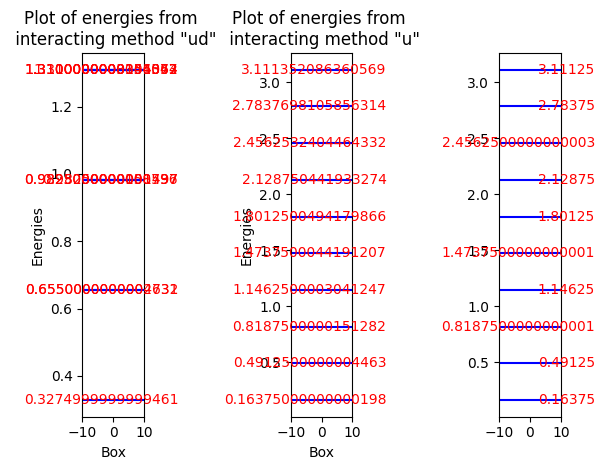

In [5]:
# plot the energies

# energies_double = np.round(energies_double, decimals=7)
# energies_single = np.round(energies_single, decimals=7)
# analytic_energies = np.round(analytic_energies, decimals=7)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_xlim(-10, 10)
ax2.set_xlim(-10, 10)
ax3.set_xlim(-10, 10)
for i, value in enumerate(energies_double):
    ax1.axhline(y=value, color='b', linestyle='-')
    if energies_double[i] == energies_double[i-1]:
        ax1.text(x=21, y=value, s=f'{value}', color='black', va='center', ha='right')
    else:
        ax1.text(x=21, y=value, s=f'{value}', color='red', va='center', ha='right')

for i, value in enumerate(energies_single):
    ax2.axhline(y=value, color='b', linestyle='-')
    ax2.text(x=21, y=value, s=f'{value}', color='red', va='center', ha='right')

for i, value in enumerate(analytic_energies):
    ax3.axhline(y=value, color='b', linestyle='-')
    ax3.text(x=21, y=value, s=f'{value}', color='red', va='center', ha='right')

ax1.set_title('Plot of energies from \n interacting method "ud"')
ax2.set_title('Plot of energies from \n interacting method "u"')
ax1.set_xlabel("Box")
ax1.set_ylabel("Energies")
ax2.set_xlabel("Box")
ax2.set_ylabel("Energies")
plt.tight_layout()
plt.savefig("qho_energy_levels")
plt.show()

In [6]:
for i in range(len(energies_single)):
    print(f"State {i}: Got {energies_single[i]}, Expected {analytic_energies[i]}")

State 0: Got 0.16375000000000198, Expected 0.16375
State 1: Got 0.4912500000004463, Expected 0.49125
State 2: Got 0.8187500000151282, Expected 0.8187500000000001
State 3: Got 1.1462500003041247, Expected 1.14625
State 4: Got 1.4737500044191207, Expected 1.4737500000000001
State 5: Got 1.8012500494179866, Expected 1.80125
State 6: Got 2.128750441933274, Expected 2.12875
State 7: Got 2.4562532404464332, Expected 2.4562500000000003
State 8: Got 2.7837698105856314, Expected 2.78375
State 9: Got 3.111352086360569, Expected 3.11125


In [ ]:
print("THIS IS A TEST FOR GIT COMMITS")